# Day 15: Decisions Under Uncertainty

---

Further reading:

- Section 2.2.1 Types of Uncertainty in my [PhD thesis](https://purl.stanford.edu/xy114jv5352)
- Der Kiureghian and Ditlevsen, "Aleatory or epistemic? Does it matter?" [link](https://www.sciencedirect.com/science/article/pii/S0167473008000556?casa_token=wMqEeSrOI-EAAAAA:SvXSdoTgMbaRnYfJ6kSIXOW1Ahs1G7xzIv1BUIvuxuQA-cmRo9E-c15FelBcebHrHNghO7le)


In [21]:
import pandas as pd 
import grama as gr 
import numpy as np

from scipy.stats import lognorm
from plotnine import *

DF = gr.Intention()


# Aleatory vs Epistemic Uncertainty

---

- *Aleatory* uncertainty: Uncertainty due to inherent randomness
- *Epistemic* uncertainty: Uncertainty due to a lack of knowledge

*Most* real sources of uncertainty are both aleatory and epistemic.

Statistics is a toolkit for working quantitatively with mixed aleatory-epistemic uncertainty.

Note that whether a source of uncertainty is aleatory, epistemic, or both depends on the features of use case, and our intended action.


## Illustrative example: Strength of a material

Suppose we knew the distribution of strength values **exactly** for a specific material. Let's call it *unobtainium*.

### Case 1: Mean of a known distribution

Suppose we analytically compute the mean $\mu$ of a known distribution.


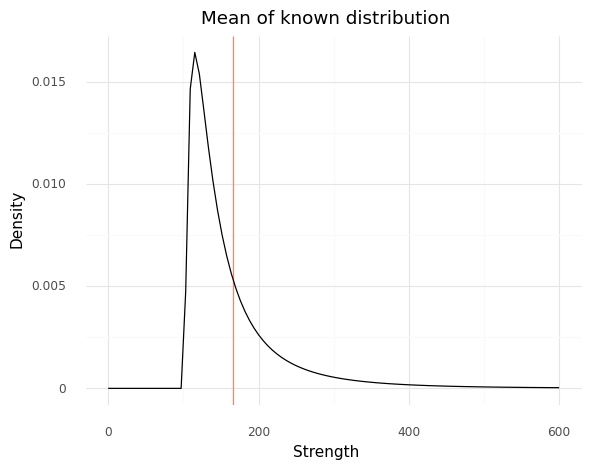

<ggplot: (8727012521433)>

In [34]:
## Define the strength distribution
param = dict(loc=100, s=1, scale=40)
marg_strength = gr.MarginalNamed(d_name="lognorm", d_param=param)
mu_exact = float(lognorm(**param).stats("m"))

## Visualize
X_strength = np.linspace(0, 600, num=100)
L_strength = list(map(marg_strength.l, X_strength))
df_pdf = gr.df_make(x=X_strength, l=L_strength)

(
    df_pdf
    >> ggplot(aes("x", "l"))
    + geom_vline(xintercept=mu_exact, color="salmon")
    + geom_line()
    
    + theme_minimal()
    + labs(
        x="Strength",
        y="Density",
        title="Mean of known distribution",
    )
)


1. Is there uncertainty in $\mu$?
2. If "yes" to (1), what kind of uncertainty does $\mu$ exhibit? Aleatory, epistemic, both, or none?

<br>
<br>
<br>

There is **no** uncertainty in $\mu$; it is known exactly!


### Case 2: Sampling a known distribution

We will sample $X \sim \rho$ from the following *known* distribution $\rho$.

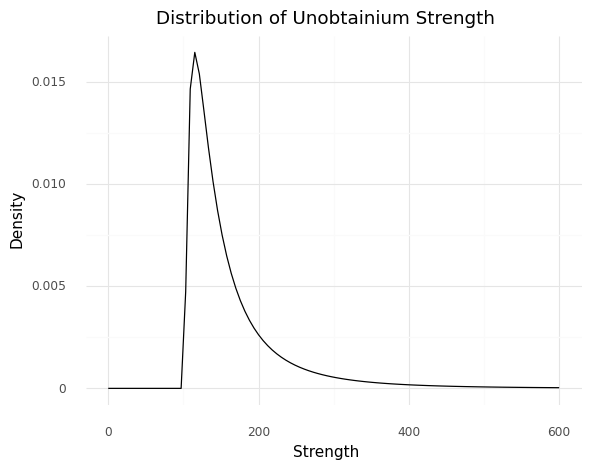

<ggplot: (8727012688116)>

In [16]:
## Define the strength distribution
marg_strength = gr.MarginalNamed(d_name="lognorm", d_param=dict(loc=100, s=1, scale=40))

## Visualize
X_strength = np.linspace(0, 600, num=100)
L_strength = list(map(marg_strength.l, X_strength))
df_pdf = gr.df_make(x=X_strength, l=L_strength)

(
    df_pdf
    >> ggplot(aes("x", "l"))
    + geom_line()
    
    + theme_minimal()
    + labs(
        x="Strength",
        y="Density",
        title="Distribution of Unobtainium Strength",
    )
)


1. Is there uncertainty in $X$?
2. If "yes" to (1), what kind of uncertainty does $X$ exhibit? Aleatory, epistemic, both, or none?

<br>
<br>
<br>

Sampling $X$ has aleatory uncertainty *only*; by construction we're assuming the distribution is known, so there is no lack of knowledge. We know everything that can possibly be known about this case.


### Case 3: Confidence interval on the mean

We have a sample $\{X_i\}_{i=1}^n$ from the distribution $X_i \stackrel{iid}{\sim} \rho$, and we use this sample to compute a confidence interval for the mean. We will **not** allow ourselves access to the true distribution when assessing the mean; we will use our sample only.


Design runtime estimates unavailable; model has no timing data.


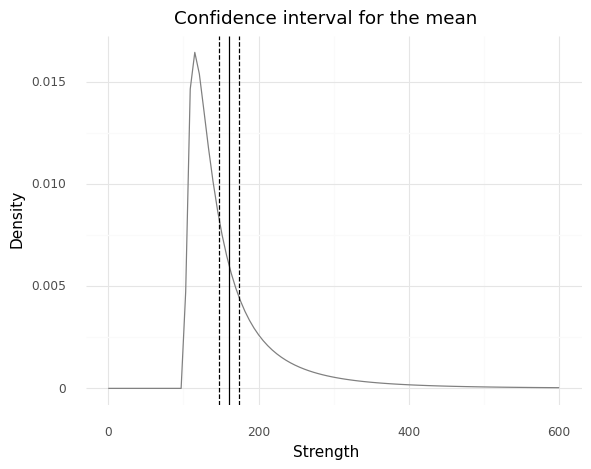

<ggplot: (8727012481699)>

In [37]:
df_sample = (
    gr.Model()
    >> gr.cp_marginals(x=marg_strength)
    >> gr.cp_copula_independence()
    >> gr.ev_monte_carlo(n=100, df_det="nom", seed=101, skip=True)
)

(
    df_sample
    >> gr.tf_summarize(
        mu_hat=gr.mean(DF.x),
        se_hat=gr.sd(DF.x) / gr.sqrt(gr.n(DF.x)),
    )
    >> gr.tf_mutate(
        mu_lo=DF.mu_hat - 1.96 * DF.se_hat,
        mu_hi=DF.mu_hat + 1.96 * DF.se_hat,
    )
    
    >> ggplot()
    + geom_line(data=df_pdf, mapping=aes("x", "l"), color="grey")
    + geom_vline(
        aes(xintercept="mu_lo"),
        linetype="dashed",
    )
    + geom_vline(
        aes(xintercept="mu_hi"),
        linetype="dashed",
    )
    + geom_vline(aes(xintercept="mu_hat"))
    
    + theme_minimal()
    + labs(
        x="Strength",
        y="Density",
        title="Confidence interval for the mean",
    )
)

1. Is there uncertainty in our estimated mean $\hat{\mu}$?
2. If "yes" to (1), what kind of uncertainty does $\hat{\mu}$ exhibit? Aleatory, epistemic, both, or none?

<br>
<br>
<br>

The estimated mean exhibits epistemic uncertainty, but not aleatory uncertainty. Here the sample is fixed, so there is no "additional randomness" that can show up; inherent randomness gave rise to uncertainty in the first place, but all of our uncertainty at this point is due to a lack of knowledge.


### Case 4: Using a fitted model for design

We have a sample $\{X_i\}_{i=1}^n$ from the distribution $X_i \stackrel{iid}{\sim} \rho$, and we use this sample to fit a model $\hat{\rho}$ that we will use for sizing a structural component.


eval_monte_carlo() is rounding n...
Design runtime estimates unavailable; model has no timing data.
eval_monte_carlo() is rounding n...
Design runtime estimates unavailable; model has no timing data.


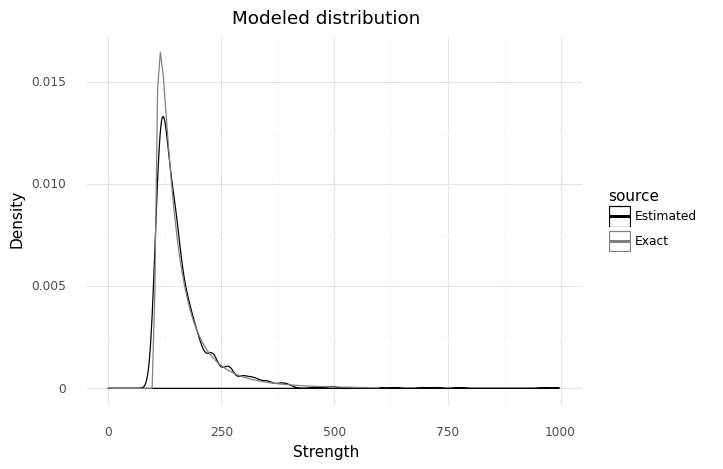

<ggplot: (8727012477962)>

In [55]:
df_sample = (
    gr.Model()
    >> gr.cp_marginals(x=marg_strength)
    >> gr.cp_copula_independence()
    >> gr.ev_monte_carlo(n=1e3, df_det="nom", seed=101, skip=True)
)

md_fit = (
    gr.Model()
    >> gr.cp_marginals(
        x=gr.marg_named(df_sample.x, "lognorm")
    )
    >> gr.cp_copula_independence()
)

(
    md_fit
    >> gr.ev_monte_carlo(n=1e3, df_det="nom", seed=103, skip=True)
    >> gr.tf_mutate(source="Estimated")
    
    >> ggplot(aes("x", color="source"))
    + geom_density()
    + geom_line(
        data=df_pdf
        >> gr.tf_mutate(source="Exact"),
        mapping=aes(y="l"),
    )
    
    + scale_color_manual(values=dict(Estimated="black", Exact="grey"))
    + theme_minimal()
    + labs(
        x="Strength",
        y="Density",
        title="Modeled distribution",
    )
)


1. Is there uncertainty in the performance of a structure designed using the `Estimated` model?
2. If "yes" to (1), what kind of uncertainty does the resulting structure exhibit? Aleatory, epistemic, both, or none?

<br>
<br>
<br>

The resulting structure will have both epistemic and aleatory uncertainty. We've already seen that the underlying material property $X$ is inherently random (aleatory uncertainty). However, the model used to design the structure was based on limited information, which means there is epistemic uncertainty "baked into" the design.
